# Fitting the Ringdown of GW150914  to a Sum of Exponentials
## Don MacMillen

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

You will have better results viewing this notebook on the nbviewer hosted by the Jupyter project rather than on github.  Look at the following:

https://nbviewer.jupyter.org/github/macd/dbm_notebooks/blob/master/ringdown_fit.ipynb

The recent discovery of the gravity wave \[1\] from a binary black hole merger makes for exciting times in Astronomy and Physics.  Even better, all of the data and much of the analysis has been [made open](https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html) so that even amateurs like me can have fun partying on it.

First a quick overview. The gravity wave GW150914 consists of three regimes.  First is due to the in-spiral, where the binary black hole system is spiraling in ever closer together.  Here both the amplitude and the frequency are increasing on the way to the merger.  The second phase is the merger, when the holes coalese into one.  This corresponds to roughly the peak of the waveform. Finally the perturbed combined black hole goes through a damped oscillation as it relaxes back to a ground state and this is called the ringdown. The ringdown is expected to be composed of quasi normal modes of the combined black hole.  They are called quasi because they are heavily damped. It is this part of the waveform that we would like to fit with a sum of complex exponentials.

Fitting sums of exponentials has a long history and it turns out that it can be very difficult to do so. The difficulty arises when we have a real component to one (or many) of the exponential parameters which means we either have an damped or amplified component in the sum.  When a fitting routine or optimizer is searching parameter space for the best fit, it can be in a regime where only one term of the sum is effectively contributing to the objective function.  Bad things can happen here, since the residual error seems to be independent of many of the parameters we are trying to fit.

One technique \[2\] used in the gravity wave community \[3\] goes by the name of [Prony's method](https://en.wikipedia.org/wiki/Prony%27s_method) and has origins dating back to 1795. More recent work \[4\] uses a method named greedy-OLS (greedy ordinary linear least squares) and can be seen [here](http://arxiv.org/pdf/1404.3197.pdf).

We are going to take a different approach and use an algorithm called Varpro \[5\].  This algorithm uses the observation that many nonlinear least squares problems that also include linear parameters.  If one were to use only a single non-linear least squares minimization algorithm, then both the linear and non-linear parameters would need to be considered by the optimizer. However, if the variables are **separable**, that is, if the model has both linear and nonlinear parameters that appear in a particular way, then another approach can be used.

The residual vector is given by the data minus the model at the m sampled points.  For a separable problem, we can write that vector as [6]

$$ ~{r_i (\textbf{a}, \boldsymbol\alpha) = y_i - \sum_{j=1}^n a_j * \phi(\boldsymbol\alpha; t_i)} $$

where $\textbf{a}$ is the vector of linear parameters and $\boldsymbol\alpha$ is the vector of nonlinear parameters.

The insight used by Varpro is that the problem of minimizing the square sum of the residuals is that it can be recast into another problem that eliminates the linear variables while the maintaining the same solution for the nonlinear variables.  One then solves the recast problem using a standard nonlinear least squares solver that needs to consider only the nonlinear variables.  When these are found, they are then used in the final **linear** least squares solutuon for the linear variables $\textbf{a}$

So we note that our sum of complex exponentials is exactly in the form of the equation given above.  This makes Varpro an great approach to this problem as is evidenced by the recent book on exponential data fitting \[7\].  A recent excellent exposition of many of the approaches to exponential data fitting is the applied mathematics [thesis](http://www.caam.rice.edu/tech_reports/2014/TR14-02.pdf) in [8] by Hokanson.

The version of Varpro that we will use is a Julia translation of the Matlab version by [O'Leary and Rust](http://www.cs.umd.edu/~oleary/software/varpro.pdf) \[9\].  The Julia version can be found at https://github.com/macd/Varpro.jl. Besides being translated in Julia, this version has also been extended to handle complex residual vectors with complex linear and nonlinear parameters.  Also, this version of Varpro uses a "golden oldie" for the nonlinear least squares solver: NL2SOL \[10\] \[11\].  The reason for that is that this optimization routine has proven to be very robust compared to Levenberg Marquardt, especially in the large residual and/or bad initial guess regime.  The original FORTRAN code has been wrapped using Julia's metaprogramming and interface features so that it can be called directly from Julia and can directly use Julia functions for the gradient and jacobian calculation.  It can be found at https://github.com/macd/NL2sol.jl. 

One of the helpful features used in the search for gravity waves is that the scientists involved knew what to look for. That is because many binary black hole mergers have been simulated with [numerical relativity](https://en.wikipedia.org/wiki/Numerical_relativity).
Below we load and plot the results from a numerical relativity simulation that is thought to best match GW150914.

In [1]:
using Formatting
using PyPlot
using DelimitedFiles

In [2]:
nrgw = readdlm("data/GW150914_4_NR_waveform.txt");

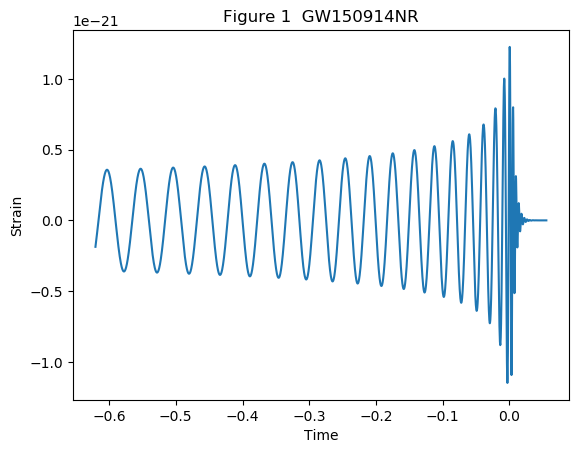

In [3]:
pg = plot(nrgw[:,1], nrgw[:,2])

xlabel("Time")
ylabel("Strain")
title("Figure 1  GW150914NR");

We will take the t = 0.0 point as the beginning of the ringdown.  Here is what it looks like.

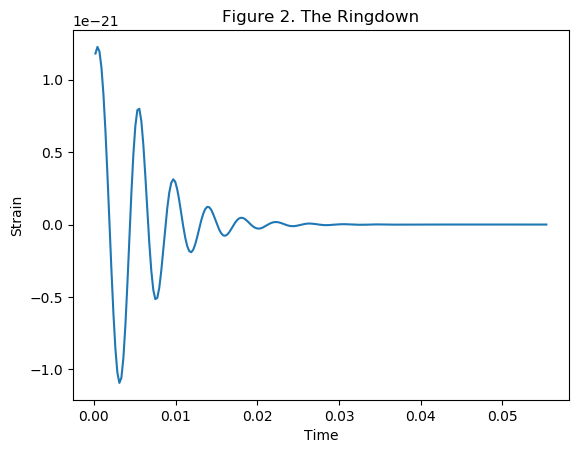

In [4]:
nrrd = nrgw[nrgw[:, 1] .>= 0.0, :]
plot(nrrd[:,1], nrrd[:,2])
title("Figure 2. The Ringdown")
xlabel("Time")
ylabel("Strain");

As you can see, it is heavily damped.  While this is an appealing figure, it is hard to see the oscillations beyond about t = 0.025.  Therefore we will switch to viewing the log(abs(y))

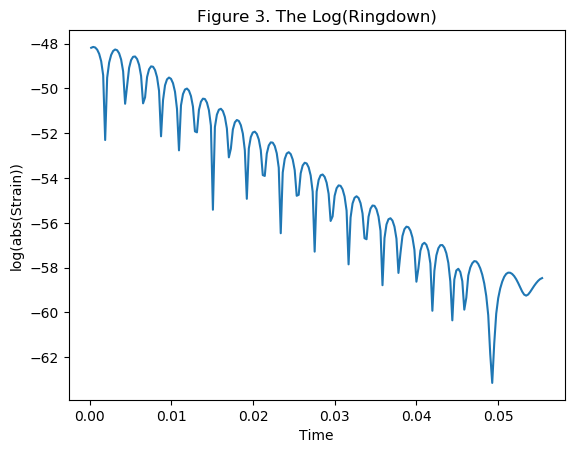

In [5]:
plot(nrrd[:,1], log.(abs.(nrrd[:,2])))
title("Figure 3. The Log(Ringdown)")
xlabel("Time")
ylabel("log(abs(Strain))");

Now we can clearly see the oscillations all the way out to the limits of the data.

As this is our example of a "perfect" waveform, we will spend some time experimenting with the modeling before tackling waveforms with measurement noise. (Well, it is also possible that this waveform has noise too: numerical noise and that looks possible out past t = 0.04).

We first set up the calculation of the phi and dphi [9] matrices which roughly correspond to the gradient and the jacobian.

In [6]:
using Varpro

function f_exp(alpha, ctx)
    for i in 1:ctx.m
        for j = 1:ctx.n
            ctx.phi[i, j] = exp(-alpha[j] * ctx.t[i])
        end
    end
    ctx.phi
end

function g_exp(alpha, ctx)
    for i in 1:ctx.m
        ctx.dphi[i, :] = -ctx.t[i] * ctx.phi[i, :]
    end
    ctx.dphi
end

""" Fit n complex exponentials to the measured data """
function exp_fit(n, y, t, x_init; verbose=true)
    w = ones(length(t))                           # weighting vector
    ind = [collect(1:n)'; collect(1:n)']          # structure of dphi matrix
    ctx = FitContext(y, t, w, x_init, n, ind, f_exp, g_exp)   # create FitContext
    ctx.verbose = verbose
    ctx.mxfcal = 500                              # new value for NL2sol's max function calls
    ctx.mxiter = 500                              # new value for NL2sol's max iterations
    (alpha, c, wresid, resid_norm, y_est, regression) = varpro(ctx)
end

# pretty print the complex parameters
function pcmplx(x, c)
    for i in 1:length(x)
        printfmt("   x[{}] {:13.6e}  {:13.6e}im    c[{}] {:13.6e}  {:13.6e}im\n",
                 i, real(x[i]), imag(x[i]), i, real(c[i]), imag(c[i]))
    end
end;


We can now peform a waveform fit the NR ringdown template.  Note the scale on the above graph which is 1e-21, which is very small.  It turns out that scaling does matter here, so we scale up all the waveforms by a factor that makes the maximum of the NR ringdown template 10.0

In [7]:
scale = 10.0 / maximum(abs.(nrrd[:, 2]))
t_nr = nrrd[:, 1]
y_nr = complex(scale * nrrd[:, 2])  # must be complex when x_init is complex
x_init = complex.([1.], [1.])
x, c, resid, resid_norm, y_est, reg = exp_fit(1, y_nr, t_nr, x_init);


NL2sol return code: both x and relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,1.0]
 * Minimizer: [194.64721621144363,-1326.4254143482647]
 * Minimum: 2.770793e+02
 * Iterations: 23
 * Convergence: true
   * |x - x'| < 7.4e-09: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 29
 * Gradient Calls: 24

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[4.613174231801944 - 6.3261821004870615im]
 Nonlinear Parameters: Complex{Float64}[194.64721621144363 - 1326.4254143482647im]
 Norm-squared of weighted residual  = 277.07933473989505
 Norm-squared of data vector        = 1179.3130854489493
 Norm         of weighted residual  = 16.64570018773302
 Norm         of data vector        = 34.34112819126578
 Expected error of observations     = 1.109713345848868 + 0.0im
 Coefficient of determination       = 0.76471

In [8]:
println("Norm of residual error: ", resid_norm)
pcmplx(x, c) 
@show(x)
@show(c)

Norm of residual error: 16.64570018773302
   x[1]  1.946472e+02  -1.326425e+03im    c[1]  4.613174e+00  -6.326182e+00im
x = Complex{Float64}[194.64721621144363 - 1326.4254143482647im]
c = Complex{Float64}[4.613174231801944 - 6.3261821004870615im]


1-element Array{Complex{Float64},1}:
 4.613174231801944 - 6.3261821004870615im

So a single exponential doesn't do all that well (norm of residual ~ 17). Here is what it looks like on a log scale.

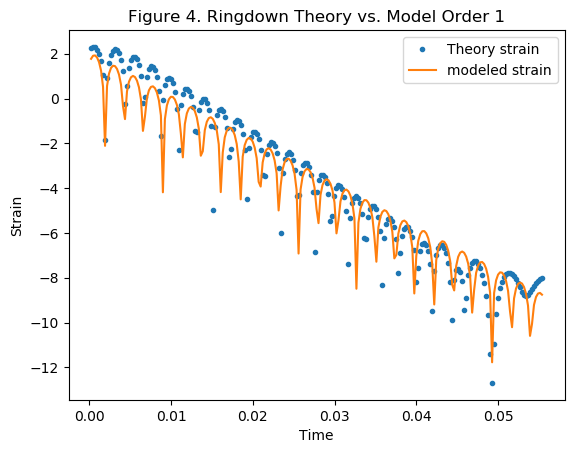

In [9]:
plot(t_nr, log.(abs.(real.(y_nr))), "o", markersize=3.0, label="Theory strain")
plot(t_nr, log.(abs.(real.(y_est))), label="modeled strain")
xlabel("Time")
ylabel("Strain")
title("Figure 4. Ringdown Theory vs. Model Order 1")
legend(loc="upper right");

So lets calculate the results for fitting orders 1 through 8 and see what we can learn

In [10]:
xx = []; cc = []; rr = []; yy_est = []
x_init = complex.([1.,1,2,2,3,3,4,4], [1.,-1,2,-2,3,-3,4,-4])   # here is magic
for i = 1:8
    println("\n---Staring problem of order $i----")
    x, c, resid, resid_norm, y_est, reg = exp_fit(i, y_nr, t_nr, x_init[1:i])
    push!(xx, x); push!(cc, c); push!(rr, resid_norm); push!(yy_est, y_est)
end;


---Staring problem of order 1----

NL2sol return code: both x and relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,1.0]
 * Minimizer: [194.64721621144363,-1326.4254143482647]
 * Minimum: 2.770793e+02
 * Iterations: 23
 * Convergence: true
   * |x - x'| < 7.4e-09: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 29
 * Gradient Calls: 24

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[4.613174231801944 - 6.3261821004870615im]
 Nonlinear Parameters: Complex{Float64}[194.64721621144363 - 1326.4254143482647im]
 Norm-squared of weighted residual  = 277.07933473989505
 Norm-squared of data vector        = 1179.3130854489493
 Norm         of weighted residual  = 16.64570018773302
 Norm         of data vector        = 34.34112819126578
 Expected error of observations     = 1.109713345848868 + 0.0im
 Coefficie

Some observations on the above optimizations.  Everytime we see a warning message from Varpro about the linear parameter not being well determined, we are in a regime where the objective functions seems to be independent of one or more of the parameters, as mentioned in the introduction.  One of the strengths of this implementation of Varpro is that it uses the SVD to solve the linear subproblem and will regularize by throwing away singular values if they are too small. This allows it to (hopefully) move through these regions unscathed.

Secondly, not all of the above runs have converged.  The problem of order 7 returned from NL2sol with a false convergence status.  This is one of the times where we did not get lucky.

We should also point out that choosing an intial starting guess can be quite an art.  Not only for converging to the "right" optimum point, but also for having an optimization path that avoids the numerical problems mentioned above.  It is a tricky subject.  See [15] for a very interesting study on this issue.

In [11]:
for i = 1:8
    printfmt("\nModel Order {}\n", i)
    println("Norm of residual error: ", rr[i])
    println("Imaginary part of y_est: ", sum(abs.(imag.(yy_est[i]))))
    pcmplx(xx[i], cc[i])
end


Model Order 1
Norm of residual error: 16.64570018773302
Imaginary part of y_est: 98.30593090210745
   x[1]  1.946472e+02  -1.326425e+03im    c[1]  4.613174e+00  -6.326182e+00im

Model Order 2
Norm of residual error: 5.6426885825845865
Imaginary part of y_est: 3.9772711902997033e-10
   x[1]  1.573650e+02  -1.367284e+03im    c[1]  2.786697e+00  -5.676483e+00im
   x[2]  1.573650e+02   1.367284e+03im    c[2]  2.786697e+00   5.676483e+00im

Model Order 3
Norm of residual error: 4.476172396437086
Imaginary part of y_est: 33.373572180496964
   x[1]  2.789034e+02   1.224594e+03im    c[1]  6.867362e+00   7.375074e-01im
   x[2]  1.541610e+02   1.534287e+03im    c[2] -3.399563e+00   2.783899e+00im
   x[3]  1.599260e+02  -1.349882e+03im    c[3]  3.346275e+00  -5.442583e+00im

Model Order 4
Norm of residual error: 0.8072093585049636
Imaginary part of y_est: 5.757033027095279e-7
   x[1]  1.878405e+02  -1.521979e+03im    c[1] -5.267854e+00  -4.630882e+00im
   x[2]  1.878405e+02   1.521979e+03im    c

Since we are fitting a real function with a set of complex linear and complex nonlinear parametes, we see the optimizer trying to find pairs of complex conjugates for the individual terms in the exponential expansion so that the imaginary parts will cancel out.  It can only do this effectively for even model orders and we can see that on some of the odd order models there is a substantial imaginary part to the estimated waveform.

There might be a fix for this, but before we do that, let's plot the last model generated (we initially called it model order 8 but is really model order 4 because of conjugate pairs) against the data from the NR simulation.

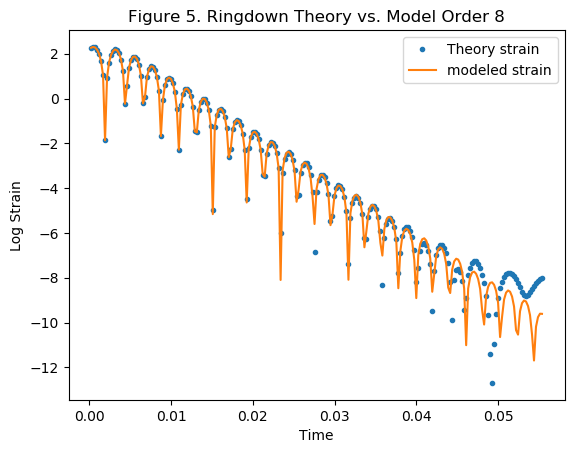

In [12]:
plot(t_nr, log.(abs.(real.(y_nr))), "o", markersize=3.0, label="Theory strain")
plot(t_nr, log.(abs.(real.(yy_est[8]))), label="modeled strain")
xlabel("Time")
ylabel("Log Strain")
title("Figure 5. Ringdown Theory vs. Model Order 8")
legend(loc="upper right");

Which actually looks pretty good and has a residual norm of only 0.012467.  Let's look at the components separately (but in conjugate pairs) to understand the fit model better.

NB: We are going to plot the log(abs(real(z))) for the total wave and the components **but** don't think that the total wave is the sum of the components on these logarithmic plots, because it is not. (The sum of the logs is not equal to the log of the sum)  But the plots will give us an idea if any one component dominate the contribution to the sum

In [13]:
# A hack so we can use sortperm on complex
import Base: isless
function isless(x::Complex, y::Complex)
    return abs(x) < abs(y)
end

x = xx[8]
c = cc[8]
idx = sortperm(x)

x = x[idx]
c = c[idx]

function wave!(y, x, c, t)
    for i in 1:length(y)
        y[i] = zero(Complex{Float64})
        for j in 1:length(x)
            y[i] += c[j] * exp(-x[j] * t[i])
        end
    end
end;

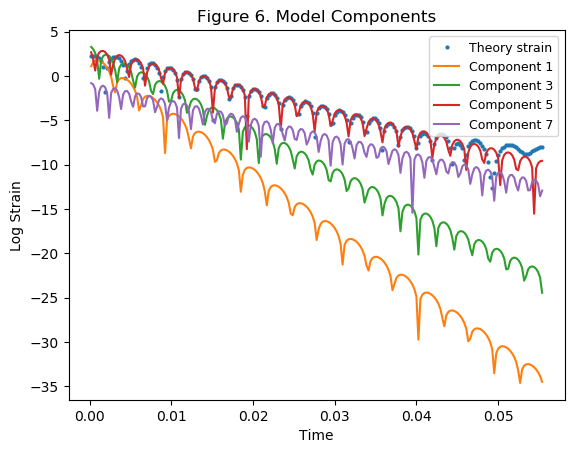

In [16]:
# Plotting here is a little different. Needed font_manager to make the legend smaller.
using PyCall

y = zeros(Complex{Float64}, length(t_nr))

fm = pyimport("matplotlib.font_manager")
prop = fm.FontProperties(size=9)
fig, ax = PyPlot.subplots()

ax.plot(t_nr, log.(abs.(real.(y_nr))), "o", markersize=2.0, label="Theory strain")

for i = 1:2:8
    wave!(y, x[i:i+1], c[i:i+1], t_nr)
    ax.plot(t_nr, log.(abs.(real.(y))), label="Component $i")
end

xlabel("Time")
ylabel("Log Strain")
title("Figure 6. Model Components")
ax.legend(loc="upper right", prop=prop);

Figure 6 is an interesting result.  It looks like a single conjugate pair, labelled here as component 5, can describe well most of the ringdown.  Components 1 and 3 fall off rapidly compared to 5 and 7, as we can see from the real parts of the x vector printed below.  They are relatively 6.5 and 4.5 verses 2.3 and 2.0.  The single component model does not match well at small times and the components labeled 1 and 3 appear to be utilized to fit the data at small times.

In [17]:
pcmplx(x, c)

   x[1]  6.511546e+02  -1.013462e+03im    c[1] -3.999688e-01   6.579656e+00im
   x[2]  6.511546e+02   1.013462e+03im    c[2] -3.999700e-01  -6.579657e+00im
   x[3]  4.588044e+02  -1.446724e+03im    c[3]  1.490606e+01  -1.362752e+00im
   x[4]  4.588044e+02   1.446724e+03im    c[4]  1.490606e+01   1.362752e+00im
   x[5]  2.309947e+02   1.519167e+03im    c[5] -1.025657e+01   7.178566e+00im
   x[6]  2.309947e+02  -1.519167e+03im    c[6] -1.025657e+01  -7.178566e+00im
   x[7]  2.010129e+02  -2.200304e+03im    c[7]  2.021128e-01  -1.196785e-01im
   x[8]  2.010129e+02   2.200304e+03im    c[8]  2.021128e-01   1.196785e-01im


The short time behavior of the above waveform may have some of the merger phase and so is not modeled well by a single conjugate pair.  We might be tempted to call the time slice from approximately 0.005 to about 0.04 as the ringdown given the above graph. Let's see what that looks like.

In [18]:
idx = 0.005 .< t_nr .< 0.04
t_nr_trunc = t_nr[idx]
y_nr_trunc = y_nr[idx]
# Use previous solution as starting guess
x_init = x[5:8]
x_all_sv = copy(x)
x_init_sv = copy(x_init)  # save for later
x, c, resid, resid_norm, y_est, reg = exp_fit(4, y_nr_trunc, t_nr_trunc, x_init)
pcmplx(x, c)


NL2sol return code: relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [230.9946767266111,230.9946784375256, ...]
 * Minimizer: [220.80861681493505,220.80861681405295, ...]
 * Minimum: 1.697036e-02
 * Iterations: 13
 * Convergence: true
   * |x - x'| < 2.8e-08: false
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: true
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 15
 * Gradient Calls: 14

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[-6.802093738508714 + 8.100685623785054im, -6.802093738319117 - 8.100685623801333im, 7.149616379688961 + 4.819674387227221im, 7.149616380914583 - 4.819674387215162im]
 Nonlinear Parameters: Complex{Float64}[220.80861681493505 + 1505.0162677863354im, 220.80861681405295 - 1505.016267785552im, 481.4341678873064 - 1232.3066942155806im, 481.43416789934696 + 1232.3066942363137im]
 Norm-squared of weighted residual  = 0.016970356603112777

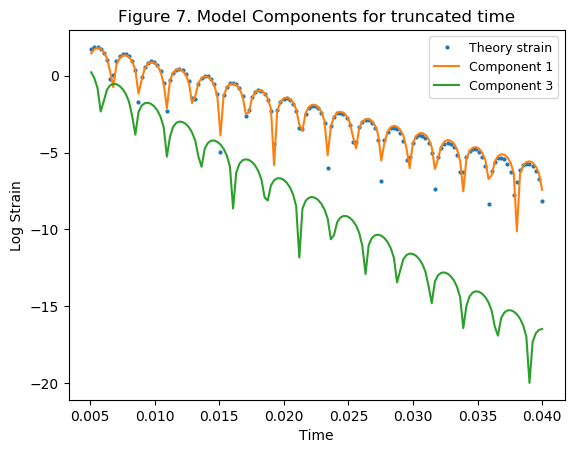

In [21]:
y = zeros(Complex{Float64}, length(t_nr_trunc))
prop = fm.FontProperties(size=9)
fig, ax = PyPlot.subplots()

ax.plot(t_nr_trunc, log.(abs.(real.(y_nr_trunc))), "o", markersize=2.0, label="Theory strain")

for i = 1:2:4
    wave!(y, x[i:i+1], c[i:i+1], t_nr_trunc)
    ax.plot(t_nr_trunc, log.(abs.(real.(y))), label="Component $i")
end

xlabel("Time")
ylabel("Log Strain")
title("Figure 7. Model Components for truncated time")
ax.legend(loc="upper right", prop=prop);

Turning now to the issue of requiring the optimizer to consider both parts of a conjugate pair separately and thus doubling the work, we'd like to see if we can remedy that situation.

The real $\boldsymbol{gw}$ waveform as a function of complex parameters cannot be analytic in the complex plane. (If $\boldsymbol{gw = u + iv}$ and $\boldsymbol{gw}$ is real, then **v** must be zero and then the Cauchy-Riemann equations are not valid). So the recipe is one of adding an imaginary part, **i \* v** (where **v** is real), to the gravity wave in order to make it an analytic signal.  Of course the **v** that we need to add cannot be arbitrary, since **u** and **v** must satisfy Cauchy-Riemann.

The insight into this was used by Gabor \[12\] in developing the concept of the **analytic signal** (also sometimes called the **complex analytic signal**\[13\]).  Since $\boldsymbol{gw}$  is real, it's Fourier transform must be complex conjugate symmetric, that is it must satisfy  $ \widehat{gw}(-\nu) = \widehat{gw}^*(\nu) $, where the hat denotes the Fourier transform. This shows that the negative frequencies not do carry any information that is not present in the positive frequency spectrum.  This suggests that we create a signal $z(t)$ as the following

$$ ~{z(t) = ~\int_{-\infty}^{\infty} \hat{z}(\nu) e^{-2 \pi i \nu t} d \nu}$$

where $ \hat{z}(\nu) = \widehat{gw}(\nu) $ when $ \nu \geq 0 $ and $ \hat{z}(\nu) = 0 $ when $ \nu \lt 0 $.

This means that the signal $\boldsymbol{z}(t)$ is complex and moreover, it turns out to be analytic.  Additionally, the real part of $\boldsymbol{z}$ is just $\boldsymbol{gw}$.  If we call the imaginary part of $\boldsymbol{z}$ $\boldsymbol{gi}$, then these two functions form a Hilbert transform pair:

$$ gi(t) = \frac{1}{\pi} \boldsymbol{P} \int_{-\infty}^{\infty} \frac{gw(t')}{t' - t} dt'$$

$$ gw(t) = - \frac{1}{\pi} \boldsymbol{P} \int_{-\infty}^{\infty} \frac{gi(t')}{t' - t} dt'$$

where $\boldsymbol{P}$ denotes the Cauchy principal value. The complex analytic signal is then written as:

$$ z(t) = gw(t) + i * gi(t) $$

Now it turns out that there are some subtlies when computing a discrete time analytic signal \[14\].  Fortunately, that is all done for us in the Julia DSP package with the function **hilbert**, which returns the complex analytic vector $\boldsymbol{z}$  given the real vector $\boldsymbol{gw}$.

So the upshot of all this math is that we fit the complex waveform $\boldsymbol{z}$ given by the **hilbert** function rather than the original real waveform $\boldsymbol{gw}$ but now we only need one half the number of exponentials in the fitting function to get to the same descriptive power.

Cool idea, but does it work?  To find out we need to look at a synthetic waveform where we know the results before hand rather than using the results of a numerical relativity simulation. Here we will look at a simple two term exponential. Although we are creating a complex waveform, we will only (for now) look at the real part.

In [23]:
# remove when running whole notebook
#using PyPlot

# Generate synthetic data to fit to a sum of exponentials
function sumexp(a, b, t)
    m = length(t)
    n = length(a)
    length(b) == n || error("length of a and b must match")
    y = zeros(eltype(b), m)
    for i = 1:m
        for j = 1:n
            y[i] += a[j] * exp(-b[j]*t[i])
        end
    end
    y
end

ts = collect(range(0.0, stop=10.0, length=2000))
a  = [.1, 2]
b = [1 - 10im, 0.8 - 13im]
ys = sumexp(a, b, ts);

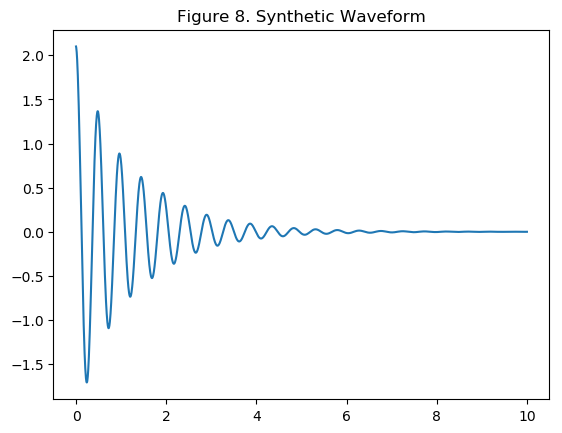

In [24]:
plot(ts, real(ys))
title("Figure 8. Synthetic Waveform");

So at first blush this looks like a ringdown waveform.  Let's look at it on a log scale.  First we get the component waveforms

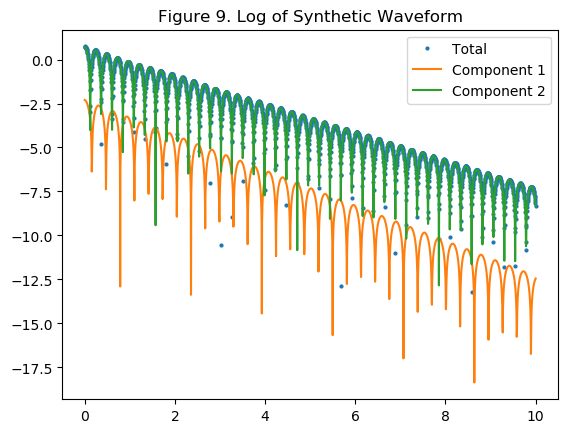

In [26]:
yc1 = sumexp(a[1], b[1], ts)
yc2 = sumexp(a[2], b[2], ts)

plot(ts, log.(abs.(real.(ys))), "o", markersize=2.0, label="Total")
plot(ts, log.(abs.(real.(yc1))), label="Component 1")
plot(ts, log.(abs.(real.(yc2))), label="Component 2")
title("Figure 9. Log of Synthetic Waveform")
legend(loc="upper right");

So we see that component two dominates this waveform which is what we would expect given that its amplitude is 20 times that of component one, but remember the total is not given by the sum of the components on this logarithmic plot.  We can only say that component two is very close to the total waveform.

Let's use the full complex waveform (ie $\boldsymbol{z}(t)$ and one that we would not have for a real $\boldsymbol{gw}(t)$ ) to see if we can correctly recover the parameters

In [28]:
x_init = [1. + 1im, 2 + 2im]
x, c, resid, resid_norm, y_est, reg = exp_fit(2, ys, ts, x_init)
pcmplx(x, c)


NL2sol return code: x convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,2.0,1.0,2.0]
 * Minimizer: [1.0000000000000413,0.7999999999999989, ...]
 * Minimum: 5.516955e-28
 * Iterations: 23
 * Convergence: true
   * |x - x'| < 4.0e-10: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 31
 * Gradient Calls: 24

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[0.10000000000000431 - 2.3314683517128287e-15im, 1.999999999999996 + 1.27675647831893e-15im]
 Nonlinear Parameters: Complex{Float64}[1.0000000000000413 - 10.000000000000046im, 0.7999999999999989 - 13.0im]
 Norm-squared of weighted residual  = 5.516955110921853e-28
 Norm-squared of data vector        = 514.7162436789812
 Norm         of weighted residual  = 2.348819940080945e-14
 Norm         of data vector        = 22.68735867568063
 Expected error of observations     = 5

So with the original complex waveform we can extract the parameters to the Julia Float64 epsilon (IEEE double precision).

If we only use the real part of the waveform, then we must double the number of exponentials to four.  Also we need to give the initial starting guess as complex conjugate pairs. The final tweak is that we must use **twice** the real part of the original complex signal because

$$ \boldsymbol{x}(t) = 2 \hspace{2pt} \boldsymbol{Re} \hspace{2pt} \boldsymbol{z}(t) $$

(See \[13\] Chapter 3)

In [30]:
x_init = [1. + 1.0im, 1. - 1.0im, 2 + 2im, 2. - 2im]
x, c, resid, resid_norm, y_est, reg = exp_fit(4, complex(2.0 * real(ys)), ts, x_init)
pcmplx(x, c)


NL2sol return code: x convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,1.0,2.0,2.0,1.0,-1.0,2.0,-2.0]
 * Minimizer: [0.9999999999999948,0.9999999999999949, ...]
 * Minimum: 4.322097e-28
 * Iterations: 24
 * Convergence: true
   * |x - x'| < 1.3e-10: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 33
 * Gradient Calls: 25

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[0.10000000000000077 - 1.2036672502123249e-15im, 0.10000000000000059 + 1.1102230246251565e-16im, 2.0000000000000004 + 2.220446049250313e-16im, 1.9999999999999982 - 2.220446049250313e-16im]
 Nonlinear Parameters: Complex{Float64}[0.9999999999999948 + 9.999999999999995im, 0.9999999999999949 - 9.999999999999995im, 0.8000000000000002 + 13.0im, 0.8000000000000002 - 13.0im]
 Norm-squared of weighted residual  = 4.322096950625907e-28
 Norm-squared of data vecto

So we still can recover the parameters to about machine eps and NL2SOL only needed an extra iteration to converge.

Lets see if we can use the analytic signal for parameter recovery.

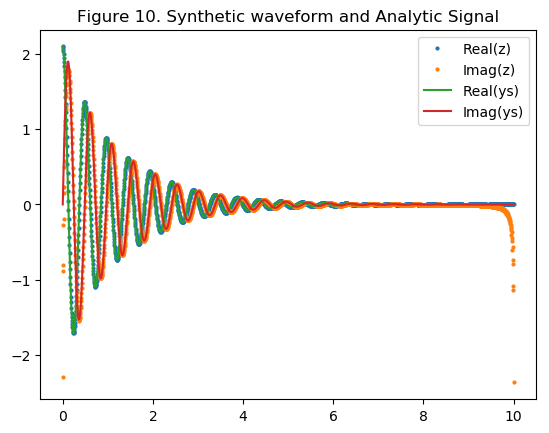

In [33]:
using DSP
z = hilbert(real(ys))

plot(ts, real(z), "o", markersize=2.0, label="Real(z)")
plot(ts, imag(z), "o", markersize=2.0, label="Imag(z)")
plot(ts, real(ys), label="Real(ys)")
plot(ts, imag(ys), label="Imag(ys)")
title("Figure 10. Synthetic waveform and Analytic Signal")
legend(loc="upper right");

Except for the regions near the ends, the hilbert function does a good job in reproducing the imaginary part of Z.  The issue at the end of the range has to do with the finite window size of the transform. We won't do anything fancy because of this, we will just back away from the edges of the region when fitting and see how good we can get.  Also, if you zoom in you will see a slight zig-zag in analytic signal z.  This is due to discretization error.

In [34]:
m = 175  # from a few runs, this seems to get close to the best 'coefficient of determination'
n = length(ts)
x_init = [1. + 1im, 2. + 2im]
x, c, resid, resid_norm, y_est, reg = exp_fit(2, z[m+1:n-m], ts[m+1:n-m], x_init)
pcmplx(x, c)


NL2sol return code: both x and relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [1.0,2.0,1.0,2.0]
 * Minimizer: [0.9924334927914154,0.7998357231898198, ...]
 * Minimum: 5.519374e-03
 * Iterations: 20
 * Convergence: true
   * |x - x'| < 3.2e-09: true
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: false
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 27
 * Gradient Calls: 21

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[0.0984145583415521 + 0.00012880280659066656im, 1.999288108287448 + 0.0002528655730035523im]
 Nonlinear Parameters: Complex{Float64}[0.9924334927914154 - 9.999189106186625im, 0.7998357231898198 - 12.999972939062614im]
 Norm-squared of weighted residual  = 0.005519373575619429
 Norm-squared of data vector        = 119.68932517361554
 Norm         of weighted residual  = 0.07429248667004915
 Norm         of data vector        = 10.940261659284733


Disappointing. It looks like using the analytic signal here is a bust.  About the best we can do is to get 2 or 3 significant digits.  

But what happens when we try to extract parameters from waves that have a significant amount of noise?  We should do a set of Monte Carlo experiments with different white noise realizations and from that calculate the bias and variance of the methods.

Work in progress... more stuff here!


The Jupyter [notebook](https://losc.ligo.org/s/events/GW150914/GW150914_tutorial.html) previously mentioned above walks us through all the signal processing necessary to extract the gravity wave signals.  I have used that notebook to dump out some relevant filtered waveform files over the time frame of the ringdown. They are

  | File name | data vector | time range |
  |:---------:|:---------:|:-----------:|
  | h1_filtered.txt | strain_H1_filt |0 < t < .057 |
  | l1_filtered.txt | strain_L1_fils | 0 < t < .057 |
  | theory_filtered.txt | NR_H1_filt | 0 < t < .057 |

  
and they are quite a bit more messy than the beautiful NR waveform above.  They are all checked into the data subdirectory of the dbm_notebooks repo.

Looking at the ringdown for both the L1 and H1 detectors, we see the following. (Note that since the long time waveforms look like they are noise dominated, there is no advantage to plotting on a log scale)

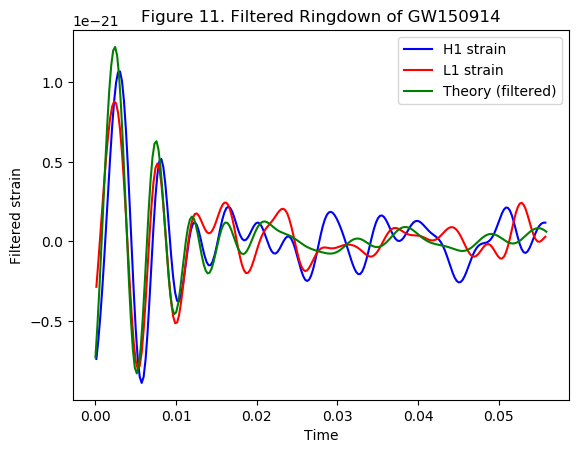

In [36]:
h1f = readdlm("data/h1_filtered.txt")
l1f = readdlm("data/l1_filtered.txt")
tf = readdlm("data/theory_filtered.txt")

plot(h1f[:, 1], h1f[:, 2], "b", label="H1 strain")
plot(l1f[:, 1], l1f[:, 2], "r", label="L1 strain")
plot(tf[:, 1], tf[:, 2], "g", label="Theory (filtered)")
title("Figure 11. Filtered Ringdown of GW150914")
legend(loc="upper right")
xlabel("Time")
ylabel("Filtered strain");

Since we have some experience with the NR (ie theory) waveform, we will start with that.

In [37]:
t_tf = tf[:, 1]
scale = 10.0 / maximum(abs.(tf[:, 2]))
#scale = 1.0
y_tf = complex.(scale .* tf[:, 2])
x, c, resid, resid_norm, y_est, reg = exp_fit(4, y_tf, t_tf, x_init_sv)
pcmplx(x, c)


NL2sol return code: relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [230.9946767266111,230.9946784375256, ...]
 * Minimizer: [150.9793458488925,150.97934584839606, ...]
 * Minimum: 2.117412e+01
 * Iterations: 13
 * Convergence: true
   * |x - x'| < 9.0e-08: false
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: true
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 14
 * Gradient Calls: 14

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[-0.6519627360868031 - 5.719604109800428im, -0.6519627360178113 + 5.7196041097679124im, -2.757113901586864 - 11.817295000368956im, -2.7571139014842228 + 11.817295000412187im]
 Nonlinear Parameters: Complex{Float64}[150.9793458488925 + 1429.5276167676718im, 150.97934584839606 - 1429.527616768894im, 405.6533857759283 - 1068.3905570240745im, 405.65338577852066 + 1068.3905570227778im]
 Norm-squared of weighted residual  = 21.17411844877

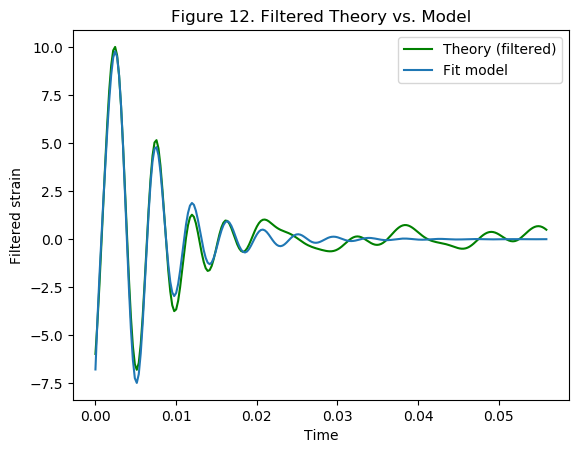

In [39]:
plot(tf[:, 1], y_tf, "g", label="Theory (filtered)")
plot(tf[:, 1], y_est, label="Fit model")
title("Figure 12. Filtered Theory vs. Model")
legend(loc="upper right")
xlabel("Time")
ylabel("Filtered strain");

And for the H1 waveform

In [40]:
t_h1f = h1f[:, 1]
scale = 10.0 / maximum(abs.(h1f[:, 2]))
y_h1f = complex.(scale .* h1f[:, 2])
x, c, resid, resid_norm, y_est, reg = exp_fit(4, y_h1f, t_h1f, x_init_sv)
pcmplx(x, c)


NL2sol return code: relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [230.9946767266111,230.9946784375256, ...]
 * Minimizer: [286.26848583105453,286.26848582833526, ...]
 * Minimum: 1.083070e+02
 * Iterations: 11
 * Convergence: true
   * |x - x'| < 3.8e-07: false
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: true
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 13
 * Gradient Calls: 12

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[-8.020688332371856 + 7.613174223131576im, -8.020688332728964 - 7.613174222803735im, 3.333271701561504 + 2.5936828914780006im, 3.3332717014653337 - 2.5936828917171697im]
 Nonlinear Parameters: Complex{Float64}[286.26848583105453 + 991.3573203339024im, 286.26848582833526 - 991.357320344981im, 117.35387521932509 - 1486.3624750133608im, 117.3538752204147 + 1486.3624750070098im]
 Norm-squared of weighted residual  = 108.30704884785625


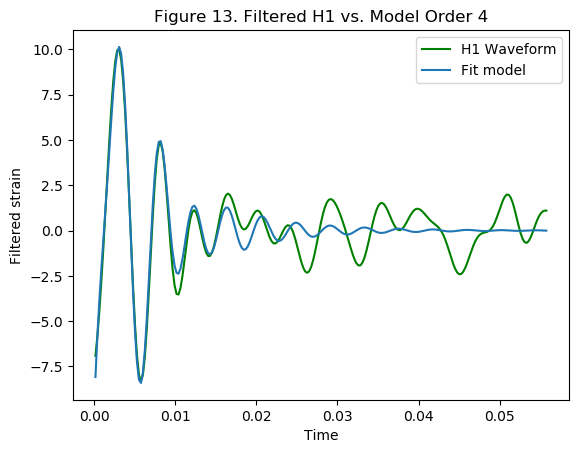

In [41]:
plot(t_h1f, y_h1f, "g", label="H1 Waveform")
plot(t_h1f, y_est, label="Fit model")
title("Figure 13. Filtered H1 vs. Model Order 4")
legend(loc="upper right")
xlabel("Time")
ylabel("Filtered strain");

Let's go for the gusto and see how well n = 8 does

In [42]:
x, c, resid, resid_norm, y_est, reg = exp_fit(8, y_h1f, t_h1f, x_all_sv)
pcmplx(x, c)

Warning from VARPRO:
   The linear parameters are currently not well-determined.
   The rank of the matrix in the subproblem is 2
   which is less than the 8 linear parameters.

NL2sol return code: relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [651.1546036064811,651.1546462512179, ...]
 * Minimizer: [139.37923831635672,139.37939431086556, ...]
 * Minimum: 7.503793e+01
 * Iterations: 46
 * Convergence: true
   * |x - x'| < 9.0e-07: false
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: true
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 57
 * Gradient Calls: 47

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[-10.751672664450172 - 2.704444914256031im, -10.75162323111698 + 2.704430610162624im, 3.446068268950503 - 1.7777050848677052im, 3.4460212525429523 + 1.7777214229425349im, 2.715931576573029 - 1.0030057415045883im, 2.7159325974561175 + 1.0030045572201836im, 0.

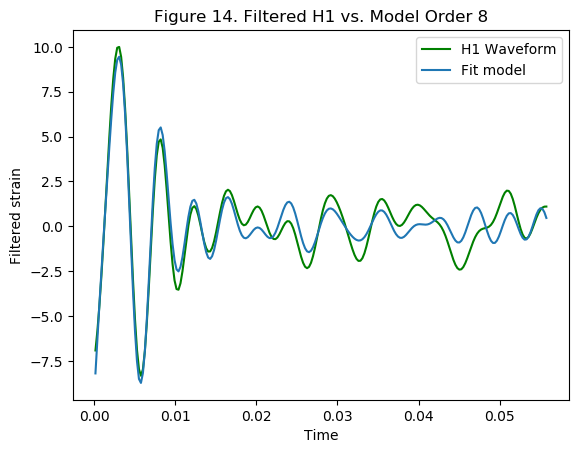

In [43]:
plot(t_h1f, y_h1f, "g", label="H1 Waveform")
plot(t_h1f, y_est, label="Fit model")
title("Figure 14. Filtered H1 vs. Model Order 8")
legend(loc="upper right")
xlabel("Time")
ylabel("Filtered strain");

So the norm of the residual goes from 10.4 down to 8.7 and the fit does look a little better, but my take is that we are overfitting to the noise particularly since the ringdown components should be very small out beyond 0.03 given the exponential damping.

and finally for the L1 waveform

In [44]:
t_l1f = l1f[:, 1]
scale = 10.0 / maximum(abs.(l1f[:, 2]))
y_l1f = complex.(scale .* l1f[:, 2])
x, c, resid, resid_norm, y_est, reg = exp_fit(4, y_l1f, t_l1f, x_init_sv)
pcmplx(x, c)


NL2sol return code: relative function convergence

results = Results of Optimization Algorithm
 * Algorithm: nl2sol
 * Starting Point: [230.9946767266111,230.9946784375256, ...]
 * Minimizer: [145.55869101033517,145.55869102111265, ...]
 * Minimum: 1.462097e+02
 * Iterations: 14
 * Convergence: true
   * |x - x'| < 6.6e-08: false
   * |f(x) - f(x')| / |f(x)| < 0.0e+00: true
   * |g(x)| < 0.0e+00: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 16
 * Gradient Calls: 15

 
VARPRO Results:
 Linear Parameters: Complex{Float64}[3.3874402685110367 - 4.626874929868785im, 3.387440268506551 + 4.6268749306350765im, -6.424188935045477 - 11.976255219127498im, -6.4241889353526895 + 11.976255218231486im]
 Nonlinear Parameters: Complex{Float64}[145.55869101033517 + 1477.8675570670114im, 145.55869102111265 - 1477.8675570544979im, 289.90681982249777 - 1090.5934516530476im, 289.9068198102886 + 1090.5934516546076im]
 Norm-squared of weighted residual  = 146.2097301396

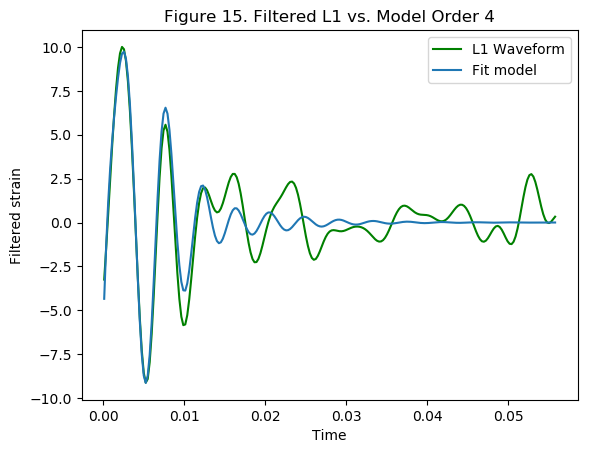

In [45]:
plot(t_l1f, y_l1f, "g", label="L1 Waveform")
plot(t_l1f, y_est, label="Fit model")
title("Figure 15. Filtered L1 vs. Model Order 4")
legend(loc="upper right")
xlabel("Time")
ylabel("Filtered strain");

## References

[1] B. Abbott et al., **[Observation of Gravitational Waves from a Binary Black Hole Merger](https://dcc.ligo.org/LIGO-P150914/public/main)**, Phys. Rev. Lett. 116, 061102 (2016), 

[2] M. R. Osborne and G. K. Smyth, **[A modied prony algorithm for exponential function fitting](http://www.statsci.org/smyth/pubs/pronyexp.pdf)**," SIAM Journal of Scientic Computing, vol. 16, pp. 119-138, 1995.

[3] E.  Berti,  V.  Cardoso,  J.  A.  Gonzalez,  and  U.  Sperhake,  **[Mining  information  from binary black hole mergers: a comparison of estimation methods for complex exponentials in noise](http://arxiv.org/pdf/gr-qc/0701086.pdf)**," Phys. Rev. D, vol. 75, p. 124017, 2007.

[4] L. London, D. Shoemaker, J. Healy, **[Modeling ringdown: Beyond the fundamental quasinormal modes](http://arxiv.org/pdf/1404.3197.pdf)**, Phys. Rev. D, vol. 90, 2014

[5] G. H. Golub and V. Pereyra, **[The Differentiation of pseudo-inverses and nonlinear least squares problems whose variables separate](http://www.vpereyra.com/files/SIAMNA73.pdf)**, SIAM J. Numer Anal, vol. 10, pp. 413-32, 1973

[6] G. Golub and V. Pereyra, **[Separable nonlinear least squares: the variable projection method and its applications](https://www.researchgate.net/profile/Victor_Pereyra2/publication/216212172_Separable_nonlinear_least_squares_the_variable_projection_method_and_its_applications/links/5426c1420cf238c6ea7a86af.pdf)**, Inverse Problems 19 (2), R1–R26 2003

[7] V. Pereyra and G. Scherer, **[Exponential Data Fitting and Its Applications](http://www.vpereyra.com/files/EDFC1.pdf)**, Bentham Books, ISBN: 978-1-60805-048-2, 2010

[8] J. Hokanson, **[Numerically Stable and Statistically Efficient Algorithms for Large Scale
Exponential Fitting](https://scholarship.rice.edu/bitstream/handle/1911/77161/thesis_final.pdf?sequence=1&isAllowed=y)**, Rice University, 2013

[9] D.P. O'Leary and B.W. Rust, **[Variable Projection for Nonlinear Least Squares Problems](http://www.cs.umd.edu/~oleary/software/varpro.pdf)**,
Computational Optimization and Applications April 2013, Volume 54, Issue 3, pp 579-593

[10] J.E. Dennis, D.M. Gay, R.E. Welsch, **An Adaptive Nonlinear Least-Squares Algorithm**, ACM Transactions on Mathematical Software (TOMS), Volume 7 Issue 3, Sept. 1981, pp 348-368, ACM New York, NY, USA [postscript version](http://ecommons.cornell.edu/bitstream/handle/1813/7442/77-321.ps?sequence=2)

[11] J.E. Dennis, D.M. Gay, R.E. Welsch, **Algorithm 573: NL2SOL—An Adaptive Nonlinear Least-Squares Algorithm**, ACM Transactions on Mathematical Software (TOMS), Volume 7 Issue 3, Sept. 1981, pp 369-383, ACM New York, NY, USA

[12] D. Gabor, [**Theory of Communication, Part 1**](http://www.csee.wvu.edu/~xinl/library/papers/physics/gabor1946.pdf), J. Inst. of Elect. Eng. Part III, Radio and Communication, vol 93, p. 429 1946

[13] L. Mandel and E. Wolf, **Optical Coherence and Quantum Optics**, Cambridge University Press, ISBN 0 521 41711 2, Cambridge UK, 1995

[14] S.L. Marple, **[Computing the Discrete-Time "Analytic" Signal via FFT](http://classes.engr.oregonstate.edu/eecs/winter2009/ece464/AnalyticSignal_Sept1999_SPTrans.pdf)**, IEEE Trans. Signal Processing, vol. 47, No. 9, Sept 1999.

[15]  D. Asenjo, J.D. Stevenson, D.J. Wales, D. Frenkel, **[Visualizing Basins of Attraction for Different Minimization Algorithms](http://arxiv.org/pdf/1309.7845.pdf)**, J. Phys. Chem. B, vol. 117, pp. 12717−12723, 2013